In [1]:
import os
import torch
from torch._C import device
import pytorch_lightning as pl
import numpy as np
from neural_diff_eq.problem.domain.domain3D import Polygon3D
from neural_diff_eq.problem.domain.domain1D import Interval
from neural_diff_eq.problem.condition import (DirichletCondition,
                                              DiffEqCondition,
                                              DataCondition)
from neural_diff_eq.problem import (Variable,
                                    Setting)
from neural_diff_eq.utils import laplacian, gradient
from neural_diff_eq import PINNModule
from neural_diff_eq.models.fcn import SimpleFCN
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
# Create vairables
p = Polygon3D(file_name='cornerplate.stl')
p = p.project_on_plane(plane_origin=[0,0,0], plane_normal=[0,0,1])
x = Variable(name='x', order=2, domain=p,
             train_conditions={}, val_conditions={})
t = Variable(name='t', order=1, domain=Interval(0,3),
             train_conditions={}, val_conditions={})
D = Variable(name='D',
             order=0,
             domain=Interval(low_bound=10,
                             up_bound=20),
             train_conditions={},
             val_conditions={})

In [3]:
# Create boundary condition for x
norm = torch.nn.MSELoss()
def x_dirichlet_fun(input):
    return torch.zeros_like(input['t'])
x.add_train_condition(DirichletCondition(dirichlet_fun=x_dirichlet_fun,
                                         name='dirichlet',
                                         norm=norm,
                                         batch_size=500,
                                         dataset_size=500,
                                         num_workers=4))

In [4]:
# Create boundary condition for t 
def t_dirichlet_fun(input):
    temp = torch.zeros((input['x'][:, :1].shape[0], 1), device='cuda')
    for i in range(temp.shape[0]):
        if input['x'][i, 0] > 0 and input['x'][i, 1] > 0:
            temp[i][0] = 10*(torch.cos(np.pi/40*(input['x'][i,0]-20))
                        *torch.cos(np.pi/40*(input['x'][i,1]-20)))
    return temp
t.add_train_condition(DirichletCondition(dirichlet_fun=t_dirichlet_fun,
                                         name='dirichlet',
                                         norm=norm,
                                         batch_size=500,
                                         dataset_size=500,
                                         num_workers=4,
                                         boundary_sampling_strategy='lower_bound_only'))

In [5]:
# Create pde condition 
def pde(u, input):
    return gradient(u, input['t']) - input['D']*laplacian(u, input['x'])
train_cond = DiffEqCondition(pde=pde,
                             norm=norm,
                             batch_size=2000,
                             dataset_size=2000,
                             num_workers=8)

In [6]:
# Put everything together
setup = Setting(variables=(x, t, D),
                train_conditions={'pde': train_cond},
                val_conditions={})
model = SimpleFCN(input_dim=4, width=50)
solver = PINNModule(model=model, problem=setup)

In [7]:
# Start training
trainer = pl.Trainer(gpus=1,
                     max_epochs=100,
                     limit_val_batches=0.0)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 13.1 K
------------------------------------
13.1 K    Trainable params
0         Non-trainable params
13.1 K    Total params
0.052     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: One of given dataloaders is None and it will be skipped.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

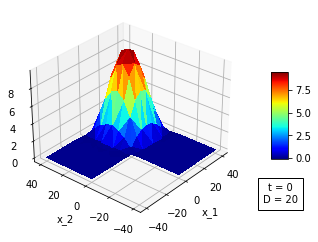

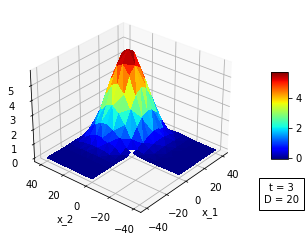

In [10]:
# Plot the solution
from neural_diff_eq.utils.plot import plot
fig = plot(model=model, plot_variables=x, points=200, angle=[30, 220], 
            dic_for_other_variables={'t' : 0, 'D' : 20})
fig = plot(model=model, plot_variables=x, points=200, angle=[30, 220], 
            dic_for_other_variables={'t' : 3, 'D' : 20})

MovieWriter ffmpeg unavailable; using Pillow instead.


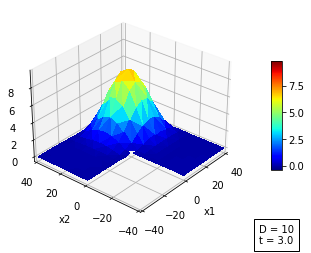

In [12]:
# Create a animation of the solution
from neural_diff_eq.utils.animation import animation
fig, ani = animation(model=model, plot_variables=x, domain_points=200, angle=[30, 220], 
                animation_variable=t, frame_number=100, dic_for_other_variables={'D' : 10})
#ani.save('heat_equation_D=10.gif')
